# 달탐사 실습



### Business Understanding

#### tl;dr

- 달 암석이 중요해도 로켓에 실을 수 있는 암석 중량에 한계가 있어서 중요한 암석을 필요한만큼 가져와야 할거야.
- 우주 비행사가 달에서 암석 채취할 때 필요한 암석과 그 중량을 정확히 채취할 수 있을까?
- 여섯 번의 아폴로 달 탐사에서 가져온 암석을 데이터 분석해서 우주 비행사에게 필요한 암석 종류와 개수를 알려줄 수 있는지 알아보자.


### Data Understanding

- NASA에서 암석 샘플 자료를 제공한다
  - https://curator.jsc.nasa.gov/lunar/samplecatalog/index.cfm
- 동일한 데이터가 Github에 올려져 있다.
  - https://github.com/drguthals/learnwithdrg/tree/main/OverTheMoon/sample-return/data

##### CSV file 읽고 DataFrame 살펴보기

In [ ]:
import pandas as pd

rock_samples = pd.read_csv("data/rocksamples.csv")
type(rock_samples)

FileNotFoundError: [Errno 2] No such file or directory: 'learnwithdrg/data/rocksamples.csv'

In [ ]:
rock_samples.head()

,ID,Mission,Type,Subtype,Weight (g),Pristine (%)
0,10001,Apollo11,Soil,Unsieved,125.8,88.36
1,10002,Apollo11,Soil,Unsieved,5629.0,93.73
2,10003,Apollo11,Basalt,Ilmenite,213.0,65.56
3,10004,Apollo11,Core,Unsieved,44.8,71.76
4,10005,Apollo11,Core,Unsieved,53.4,40.31


In [ ]:
rock_samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2229 entries, 0 to 2228
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            2229 non-null   int64  
 1   Mission       2229 non-null   object 
 2   Type          2229 non-null   object 
 3   Subtype       2226 non-null   object 
 4   Weight (g)    2229 non-null   float64
 5   Pristine (%)  2229 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 104.6+ KB


In [ ]:
# std: STandard Deviation, 표준편차
rock_samples.describe()

,ID,Weight (g),Pristine (%)
count,2229.000000,2229.000000,2229.000000
mean,52058.432032,168.253024,84.512764
std,26207.651471,637.286458,22.057299
min,10001.000000,0.000000,0.000000
25%,15437.000000,3.000000,80.010000
50%,65527.000000,10.200000,92.300000
75%,72142.000000,93.490000,98.140000
max,79537.000000,11729.000000,180.000000


In [ ]:
rock_samples.isnull().sum()

ID              0
Mission         0
Type            0
Subtype         3
Weight (g)      0
Pristine (%)    0
dtype: int64

### Data Preparation

먼저 pandas의 DataFrame에서 하나의 칼럼을 Series로 구하는 것을 살펴보자

In [ ]:
series = rock_samples['Weight (g)']
df = rock_samples[['Weight (g)']]

##### 새로운 DataFrame 생성

6번의 아폴로 달탐사 각 Mission에서 아르테미스 달탐사에서 필요한 암석 중량과 달탐사선 중량을 예측하고자 한다.  
따라서 각 Mission에 대한 Data가 필요하다.

In [ ]:
missions = pd.DataFrame()
missions['Mission'] = rock_samples['Mission'].unique()
missions

,Mission
0,Apollo11
1,Apollo12
2,Apollo14
3,Apollo15
4,Apollo16
5,Apollo17


##### Sample weight와 diff 추가

먼저 각 Mission에서 수집한 Sample 들의 무게 총합을 구하고 이를 Kg으로 바꾸어 준다.  
Column의 이름도 바꾸어 준다.

In [ ]:
total_weight = rock_samples.groupby('Mission')['Weight (g)'].sum()
missions = pd.merge(missions, total_weight, on='Mission')
missions

,Mission,Weight (g)
0,Apollo11,21554.24
1,Apollo12,34342.38
2,Apollo14,41833.63
3,Apollo15,75399.10
4,Apollo16,92462.62
5,Apollo17,109444.02


In [ ]:
missions['Weight (g)'] = missions['Weight (g)'].apply(lambda x: x * 0.001)
missions.rename(columns={'Weight (g)': 'Sample weight (kg)'}, inplace=True)
missions

,Mission,Sample weight (kg)
0,Apollo11,21.55424
1,Apollo12,34.34238
2,Apollo14,41.83363
3,Apollo15,75.39910
4,Apollo16,92.46262
5,Apollo17,109.44402


이제 각 Mission의 이전 값과의 차이를 구한다.  
맨 처음 값은 이전 값이 없기 때문에 NaN이 되는데, 이를 특정 값으로 채워준다.

In [ ]:
missions['Weight diff'] = missions['Sample weight (kg)'].diff()
missions.fillna(0, inplace=True)
missions

,Mission,Sample weight (kg),Weight diff
0,Apollo11,21.55424,0.00000
1,Apollo12,34.34238,12.78814
2,Apollo14,41.83363,7.49125
3,Apollo15,75.39910,33.56547
4,Apollo16,92.46262,17.06352
5,Apollo17,109.44402,16.98140


##### 달 탐사선 중량 데이터 추가

<<실습 5회차 자료 12page 참고>>  
각 Mission의 달 탐사선 모듈 이름, 중량, 중량 차이를 추가한다. Command 모듈에 대해서도 같은 작업을 반복한다.

In [ ]:
missions['Lunar module (LM)'] = ['Eagle (LM-5)', 'Intrepid (LM-6)', 'Antares (LM-8)', 'Falcon (LM-10)', 'Orion (LM-11)', 'Challenger (LM-12)']
missions['LM mass (kg)'] = [15103, 15235, 15264, 16430, 16445, 16456]
missions['LM mass diff'] = missions['LM mass (kg)'].diff()
missions['LM mass diff'] = missions['LM mass diff'].fillna(0)
missions

,Mission,Sample weight (kg),Weight diff,Lunar module (LM),LM mass (kg),LM mass diff
0,Apollo11,21.55424,0.00000,Eagle (LM-5),15103,0.0
1,Apollo12,34.34238,12.78814,Intrepid (LM-6),15235,132.0
2,Apollo14,41.83363,7.49125,Antares (LM-8),15264,29.0
3,Apollo15,75.39910,33.56547,Falcon (LM-10),16430,1166.0
4,Apollo16,92.46262,17.06352,Orion (LM-11),16445,15.0
5,Apollo17,109.44402,16.98140,Challenger (LM-12),16456,11.0


In [ ]:
missions['Command module (CM)'] = ['Columbia (CM-107)', 'Yankee Clipper (CM-108)', 'Kitty Hawk (CM-110)', 'Endeavor (CM-112)', 'Casper (CM-113)', 'America (CM-114)']
missions['CM mass (kg)'] = [5560, 5609, 5758, 5875, 5840, 5960]
missions['CM mass diff'] = missions['CM mass (kg)'].diff()
missions['CM mass diff'] = missions['CM mass diff'].fillna(0)
missions

,Mission,Sample weight (kg),Weight diff,Lunar module (LM),LM mass (kg),LM mass diff,Command module (CM),CM mass (kg),CM mass diff
0,Apollo11,21.55424,0.00000,Eagle (LM-5),15103,0.0,Columbia (CM-107),5560,0.0
1,Apollo12,34.34238,12.78814,Intrepid (LM-6),15235,132.0,Yankee Clipper (CM-108),5609,49.0
2,Apollo14,41.83363,7.49125,Antares (LM-8),15264,29.0,Kitty Hawk (CM-110),5758,149.0
3,Apollo15,75.39910,33.56547,Falcon (LM-10),16430,1166.0,Endeavor (CM-112),5875,117.0
4,Apollo16,92.46262,17.06352,Orion (LM-11),16445,15.0,Casper (CM-113),5840,-35.0
5,Apollo17,109.44402,16.98140,Challenger (LM-12),16456,11.0,America (CM-114),5960,120.0


##### 승무원 영역 (달 모듈 + 명령 모듈) 중량 데이터 추가

In [ ]:
missions['Total mass (kg)'] = missions['LM mass (kg)'] + missions['CM mass (kg)']
missions['Total mass diff'] = missions['LM mass diff'] + missions['CM mass diff']
missions

,Mission,Sample weight (kg),Weight diff,Lunar module (LM),LM mass (kg),LM mass diff,Command module (CM),CM mass (kg),CM mass diff,Total mass (kg),Total mass diff
0,Apollo11,21.55424,0.00000,Eagle (LM-5),15103,0.0,Columbia (CM-107),5560,0.0,20663,0.0
1,Apollo12,34.34238,12.78814,Intrepid (LM-6),15235,132.0,Yankee Clipper (CM-108),5609,49.0,20844,181.0
2,Apollo14,41.83363,7.49125,Antares (LM-8),15264,29.0,Kitty Hawk (CM-110),5758,149.0,21022,178.0
3,Apollo15,75.39910,33.56547,Falcon (LM-10),16430,1166.0,Endeavor (CM-112),5875,117.0,22305,1283.0
4,Apollo16,92.46262,17.06352,Orion (LM-11),16445,15.0,Casper (CM-113),5840,-35.0,22285,-20.0
5,Apollo17,109.44402,16.98140,Challenger (LM-12),16456,11.0,America (CM-114),5960,120.0,22416,131.0


##### Payload와 승무원 영역, 샘플이 차지하는 비율 추가

Saturn V의 Payload는 43,500 kg이라고 한다.  
다음 Field를 추가해 보자
- Payload에서 승무원 영역이 차지하는 비율
- 승무원 영역에 대한 Sample 중량 비율
- Payload에 대한 Sample 중량 비율

In [ ]:
saturn_v_payload = 43_500
missions['Crewed area / Payload'] = missions['Total mass (kg)'] / saturn_v_payload
missions['Sample / Crewed area'] = missions['Sample weight (kg)'] / missions['Total mass (kg)']
missions['Sample / Payload'] = missions['Sample weight (kg)'] / saturn_v_payload
missions

,Mission,Sample weight (kg),Weight diff,Lunar module (LM),LM mass (kg),LM mass diff,Command module (CM),CM mass (kg),CM mass diff,Total mass (kg),Total mass diff,Crewed area / Payload,Sample / Crewed area,Sample / Payload
0,Apollo11,21.55424,0.00000,Eagle (LM-5),15103,0.0,Columbia (CM-107),5560,0.0,20663,0.0,0.475011,0.001043,0.000495
1,Apollo12,34.34238,12.78814,Intrepid (LM-6),15235,132.0,Yankee Clipper (CM-108),5609,49.0,20844,181.0,0.479172,0.001648,0.000789
2,Apollo14,41.83363,7.49125,Antares (LM-8),15264,29.0,Kitty Hawk (CM-110),5758,149.0,21022,178.0,0.483264,0.001990,0.000962
3,Apollo15,75.39910,33.56547,Falcon (LM-10),16430,1166.0,Endeavor (CM-112),5875,117.0,22305,1283.0,0.512759,0.003380,0.001733
4,Apollo16,92.46262,17.06352,Orion (LM-11),16445,15.0,Casper (CM-113),5840,-35.0,22285,-20.0,0.512299,0.004149,0.002126
5,Apollo17,109.44402,16.98140,Challenger (LM-12),16456,11.0,America (CM-114),5960,120.0,22416,131.0,0.515310,0.004882,0.002516


### Modeling

##### 아르테미스 임무에서 가져올 수 있는 샘플의 무게 구하기

아르테미스 임무는 3번이 있을 예정이고, 다음과 같이 예상하고 있다.
- 승무원 영역의 무게는 모두 동일할 것으로, 26520kg 이다.
- 예상 Payload는 각각, 26988, 37965, 42955 이다.

이제 예상 데이터를 사용해 DataFrame을 새로 만들어보자

In [ ]:
artemis_crewed_area = 26_520
artemis_mission = pd.DataFrame({'Mission': ['artemis1', 'artemis1b', 'artemis2'], 
                                'Total mass (kg)': [artemis_crewed_area] * 3,
                                'Payload (kg)': [26_988, 37_965, 42_955]})
artemis_mission

,Mission,Total mass (kg),Payload (kg)
0,artemis1,26520,26988
1,artemis1b,26520,37965
2,artemis2,26520,42955


예상하는 승무원 영역의 무게와 Payload를 가지고, 각 미션에서 가져올 수 있는 샘플의 무계를 예측해보자.  
우리는 이미 과거의 데이터로부터 승무원 영역과 샘플의 비율, Payload와 샘플의 비율을 알고 있으므로 이를 이용하여 Artemis 미션에서 가져올 수 있는 샘플의 무계를 계산한다.  
각 비율의 평균을 사용하여 값을 구하고, 구한 두 값의 평귤을 최종 예상치로 사용하자.

In [ ]:
sample_payload_ratio = missions['Sample / Payload'].mean()
sample_crewed_area_ratio = missions['Sample / Crewed area'].mean()
artemis_mission['Sample weight from payload (kg)'] = artemis_mission['Payload (kg)'] * sample_payload_ratio
artemis_mission['Sample weight from total (kg)'] = artemis_mission['Total mass (kg)'] * sample_crewed_area_ratio
artemis_mission['Estimated sample weight (kg)'] = artemis_mission[['Sample weight from payload (kg)', 'Sample weight from total (kg)']].mean(axis=1)
artemis_mission

,Mission,Total mass (kg),Payload (kg),Sample weight from payload (kg),Sample weight from total (kg),Estimated sample weight (kg)
0,artemis1,26520,26988,38.779584,75.549232,57.164408
1,artemis1b,26520,37965,54.552649,75.549232,65.050940
2,artemis2,26520,42955,61.722877,75.549232,68.636054


##### 가져와야 하는 샘플을 위한 DataFrame 만들기

가져올 수 있는 무게가 한정되어 있으니, 필요한 암석을 우선해서 가져와야 한다.  
따라서 현재 가지고 있는 암석의 남은 양을 구하고 양이 적은 암석을 식별해 보자.

In [ ]:
rock_samples['Remaining (g)'] = rock_samples['Weight (g)'] * rock_samples['Pristine (%)'] / 100
rock_samples.head()
rock_samples.describe()

,ID,Weight (g),Pristine (%),Remaining (g)
count,2229.000000,2229.000000,2229.000000,2229.000000
mean,52058.432032,168.253024,84.512764,138.103386
std,26207.651471,637.286458,22.057299,525.954023
min,10001.000000,0.000000,0.000000,0.000000
25%,15437.000000,3.000000,80.010000,2.432304
50%,65527.000000,10.200000,92.300000,8.530000
75%,72142.000000,93.490000,98.140000,78.240000
max,79537.000000,11729.000000,180.000000,11169.526700


In [ ]:
low_samples = rock_samples.loc[(rock_samples['Weight (g)'] >= 160) & (rock_samples['Pristine (%)'] < 50)]
low_samples.head()

,ID,Mission,Type,Subtype,Weight (g),Pristine (%),Remaining (g)
11,10017,Apollo11,Basalt,Ilmenite,973.0,43.71,425.2983
14,10020,Apollo11,Basalt,Ilmenite,425.0,27.88,118.4900
15,10021,Apollo11,Breccia,Regolith,250.0,30.21,75.5250
29,10045,Apollo11,Basalt,Olivine,185.0,12.13,22.4405
37,10057,Apollo11,Basalt,Ilmenite,919.0,35.15,323.0285


다음을 확인해 보고 Error가 발생하는 이유를 생각해보자.


In [ ]:
rock_samples['Weight (g)'] >= 160 & rock_samples['Pristine (%)'] < 50  

In [ ]:
(rock_samples['Weight (g)'] >= 160) and (rock_samples['Pristine (%)'] < 50)

##### Artemis 임무에서 수질합 Sample을 저장한 DataFrame 생성

어떤 암석이 적은 지 low_samples에서 확인하고 이를 새로운 DataFrame으로 저장한다.

In [ ]:
low_samples.groupby('Type')['ID'].count()

Type
Basalt     14
Breccia     8
Core        1
Soil        4
Name: ID, dtype: int64

In [ ]:
needed_samples = low_samples.loc[low_samples['Type'].isin(['Basalt', 'Breccia'])]
needed_samples.head()

,ID,Mission,Type,Subtype,Weight (g),Pristine (%),Remaining (g)
11,10017,Apollo11,Basalt,Ilmenite,973.0,43.71,425.2983
14,10020,Apollo11,Basalt,Ilmenite,425.0,27.88,118.4900
15,10021,Apollo11,Breccia,Regolith,250.0,30.21,75.5250
29,10045,Apollo11,Basalt,Olivine,185.0,12.13,22.4405
37,10057,Apollo11,Basalt,Ilmenite,919.0,35.15,323.0285


Apolo 임무에서 아예 수집에 안되었던 Sample이 있지 않을까?  
이 것도 needed_samples 에 넣자!

In [ ]:
rock_samples.groupby('Type')['Weight (g)'].sum()

Type
Basalt      93140.77
Breccia    168880.75
Core        19935.87
Crustal      4744.69
Soil        87589.81
Special       744.10
Name: Weight (g), dtype: float64

In [ ]:
needed_samples = needed_samples.append(rock_samples.loc[rock_samples['Type'] == 'Crustal'])

In [ ]:
needed_samples = pd.concat([needed_samples, rock_samples.loc[rock_samples['Type'] == 'Crustal']])
needed_samples.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68 entries, 11 to 2189
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             68 non-null     int64  
 1   Mission        68 non-null     object 
 2   Type           68 non-null     object 
 3   Subtype        68 non-null     object 
 4   Weight (g)     68 non-null     float64
 5   Pristine (%)   68 non-null     float64
 6   Remaining (g)  68 non-null     float64
dtypes: float64(3), int64(1), object(3)
memory usage: 4.2+ KB


[질문] append operation은 왜 삭제되었을까?


### Evaluation

Artemis 우주 비행사에게 전달할 최종 DataFrame 만들기

In [ ]:
needed_sample_overview = pd.DataFrame()
needed_sample_overview['Type'] = needed_samples['Type'].unique()
needed_sample_overview

,Type
0,Basalt
1,Breccia
2,Crustal


In [ ]:
needed_samples.groupby('Type')['Weight (g)'].sum()

Type
Basalt     17423.40
Breccia    10118.50
Crustal     4744.69
Name: Weight (g), dtype: float64

In [ ]:
# Sample 유형별 총 중량을 구한 후, Series에 Index 를 추가하여 DataFrame으로 변환
# https://pandas.pydata.org/docs/reference/api/pandas.Series.reset_index.html
needed_sample_weights = needed_samples.groupby('Type')['Weight (g)'].sum().reset_index()
needed_sample_weights

,Type,Weight (g)
0,Basalt,17423.40
1,Breccia,10118.50
2,Crustal,4744.69


In [ ]:
# 유형별 총 중량을 needed_sample_overview에 추가
needed_sample_overview = pd.merge(needed_sample_overview, needed_sample_weights, on='Type')
needed_sample_overview

,Type,Weight (g)
0,Basalt,17423.40
1,Breccia,10118.50
2,Crustal,4744.69


In [ ]:
# g => kg 변환 하고 열 이름 변경
needed_sample_overview['Weight (g)'] = needed_sample_overview['Weight (g)'].apply(lambda x: x * 0.001)
needed_sample_overview.rename(columns={'Weight (g)': 'Total weight (kg)'}, inplace=True)
needed_sample_overview

,Type,Total weight (kg)
0,Basalt,17.42340
1,Breccia,10.11850
2,Crustal,4.74469


In [ ]:
# 유형별 평균 중량을 구해, 우주 비행사가 암석을 쉽게 식별할 수 있도록 한다.
tmp = needed_samples.groupby('Type')['Weight (g)'].mean() * 0.001
needed_sample_overview['Average weight (kg)'] = tmp.reset_index()['Weight (g)']
needed_sample_overview

,Type,Total weight (kg),Average weight (kg)
0,Basalt,17.42340,1.244529
1,Breccia,10.11850,1.264813
2,Crustal,4.74469,0.103145


In [ ]:
# 유형별 샘플 개수 추가
needed_sample_overview['Sample count'] = rock_samples.groupby('Type')['ID'].count().reset_index()['ID']
needed_sample_overview

,Type,Total weight (kg),Average weight (kg),Sample count
0,Basalt,17.42340,1.244529,351
1,Breccia,10.11850,1.264813,959
2,Crustal,4.74469,0.103145,56


In [ ]:
# 잘못된 샘플 개수 열 삭제
needed_sample_overview.drop(columns=['Sample count'], inplace=True)

# 유형별 ID에 맞추어 샘플 개수 추가
tmp = rock_samples.groupby('Type')['ID'].count().reset_index()
tmp.rename(columns={'ID': 'Number of samples'}, inplace=True)
needed_sample_overview = pd.merge(needed_sample_overview, tmp, on='Type')
needed_sample_overview

,Type,Total weight (kg),Average weight (kg),Number of samples
0,Basalt,17.42340,1.244529,351
1,Breccia,10.11850,1.264813,959
2,Crustal,4.74469,0.103145,46


In [ ]:
# 세가지 유형의 암석이 각각 차지하는 비율을 구한다.
needed_sample_overview['Percentage of rocks'] = needed_sample_overview['Number of samples'] / needed_sample_overview['Number of samples'].sum()
needed_sample_overview

,Type,Total weight (kg),Average weight (kg),Number of samples,Percentage of rocks
0,Basalt,17.42340,1.244529,351,0.258850
1,Breccia,10.11850,1.264813,959,0.707227
2,Crustal,4.74469,0.103145,46,0.033923


In [ ]:
artemis_mission

,Mission,Total mass (kg),Payload (kg),Sample weight from payload (kg),Sample weight from total (kg),Estimated sample weight (kg)
0,artemis1,26520,26988,38.779584,75.549232,57.164408
1,artemis1b,26520,37965,54.552649,75.549232,65.050940
2,artemis2,26520,42955,61.722877,75.549232,68.636054


In [ ]:
# 각 암석이 수집되어야 할 중량과 개수를 구한다.
avg_sample_weight = artemis_mission['Estimated sample weight (kg)'].mean()
needed_sample_overview['Weight to collect'] = needed_sample_overview['Percentage of rocks'] * avg_sample_weight
needed_sample_overview['Rocks to collect'] = needed_sample_overview['Weight to collect'] / needed_sample_overview['Average weight (kg)']
needed_sample_overview

,Type,Total weight (kg),Average weight (kg),Number of samples,Percentage of rocks,Weight to collect,Rocks to collect
0,Basalt,17.42340,1.244529,351,0.258850,16.467267,13.231731
1,Breccia,10.11850,1.264813,959,0.707227,44.991764,35.571884
2,Crustal,4.74469,0.103145,46,0.033923,2.158103,20.922917


<Axes: xlabel='Type', ylabel='Pristine (%)'>

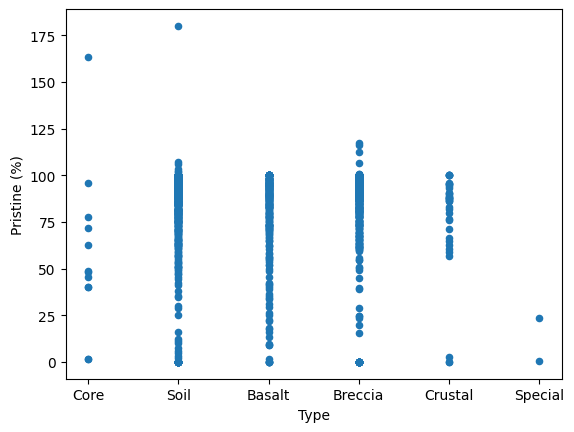

In [ ]:
rock_samples.query('`Weight (g)` < 100').plot(kind="scatter", x="Type", y="Pristine (%)")